In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os
import numpy as np
from torchvision import transforms
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import torch.nn as nn


In [2]:
transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor()#,
])

transform3 = transforms.Compose([
    transforms.Grayscale(3),
    transforms.ToTensor()#,
])

In [3]:
import os
import shutil
import random

ten_words = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
roots = ['new_spectograms/train', 'new_spectograms/test', 'new_spectograms/val']
sample_ratio = 0.05  # 5%

for root_dir in roots:
    print(f"\n--- Przetwarzanie: {root_dir} ---")

    unknown_path = os.path.join(root_dir, "unknown")
    os.makedirs(unknown_path, exist_ok=True)

    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)

        if not os.path.isdir(folder_path) or folder in ten_words or folder == "unknown":
            continue

        # Pobierz tylko pliki .wav
        wav_files = [f for f in os.listdir(folder_path) if f.endswith(".png")]
        if not wav_files:
            print(f"Pomijam folder bez plików .wav: {folder}")
            shutil.rmtree(folder_path)
            continue

        # Próbkuj 5%
        sample_size = max(1, int(len(wav_files) * sample_ratio))  
        sampled_files = random.sample(wav_files, sample_size)

        print(f"{folder}: przenoszę {sample_size} .png do 'unknown'")

        for file in sampled_files:
            src_file = os.path.join(folder_path, file)
            dst_file = os.path.join(unknown_path, f"{folder}_{file}")
            shutil.move(src_file, dst_file)

        # Usuwamy cały folder po przeniesieniu (czyli kasujemy pozostałe 95%)
        shutil.rmtree(folder_path)
        print(f"Usunięto folder: {folder}")



--- Przetwarzanie: new_spectograms/train ---

--- Przetwarzanie: new_spectograms/test ---

--- Przetwarzanie: new_spectograms/val ---


In [4]:
train_set= ImageFolder(root='new_spectograms\\train', transform=transform)
test_set = ImageFolder(root='new_spectograms\\test', transform=transform)
val_set = ImageFolder(root='new_spectograms\\val', transform=transform)

# Sprawdzenie etykiet (to jest przypisanie nazw folderów do etykiet)
class_names = train_set.classes
num_labels = len(class_names)
class_names


['down',
 'go',
 'left',
 'no',
 'off',
 'on',
 'right',
 'stop',
 'unknown',
 'up',
 'yes']

In [5]:
import torch.nn.init as init

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Linear, nn.Conv2d)): 
            init.xavier_uniform_(m.weight)  
            if m.bias is not None:
                init.zeros_(m.bias)   


In [ ]:

import timm
import torch.nn as nn
model1 = timm.create_model("deit_tiny_patch16_224")
model3 = timm.create_model("deit_tiny_patch16_224")

model1.head = nn.Linear(model1.head.in_features, 11) 
model3.head = nn.Linear(model3.head.in_features, 11) 

initialize_weights(model1)  
initialize_weights(model3)  

model1.patch_embed.proj = nn.Conv2d(1, 192, kernel_size=(16, 16), stride=(16, 16))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model1.to(device)

In [ ]:

import time
model3 = timm.create_model("deit_tiny_patch16_224")
model3.head = nn.Linear(model3.head.in_features, 11)   
initialize_weights(model3)   
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3.to(device)

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

 
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = True

print('Dataloading...')
data_loader = DataLoader(train_set, batch_size=16, num_workers=6, generator=torch.Generator(device='cpu'),pin_memory=True, shuffle=True,persistent_workers=True, prefetch_factor=4)
data_loader_val =  DataLoader(val_set, batch_size=16, num_workers=4, generator=torch.Generator(device='cpu'), persistent_workers=True, prefetch_factor=2)

#data_loader_val = DataLoader(val_set, batch_size=16, num_workers=2,persistent_workers=True, generator=torch.Generator(device='cpu'))

# Accessing the model configuration


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)
optimizer = torch.optim.AdamW(model1.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

previous_time = time.time()
for epoch in range(20):  
    model1.train()
    total_loss = 0
    correct = 0
    total = 0
    previous_time = time.time()
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = batch_X.to(device, non_blocking=True)  
        Y = batch_Y.to(device, non_blocking=True)  
        optimizer.zero_grad()
        outputs = model1(X)
        loss = criterion(outputs, Y)
        loss.backward()     
        optimizer.step()


        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == Y).sum().item()
        total += Y.size(0)
        
        print(f"Epoch {epoch + 1}, i: {i}, Loss: {total_loss / (i+1):.4f}, Accuracy: {correct / total * 100:.2f}%, last batch accuracy: {(predicted == Y).sum().item()/Y.size(0) * 100:.2f}% Time: {time.time() - previous_time:.2f}s", end='\r')
        previous_time = time.time()

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")
    train_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.2f}%")

    model1.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_Y in data_loader_val:
            X = batch_X.to(device, non_blocking=True)
            Y = batch_Y.to(device, non_blocking=True)
            outputs = model1(X)
            loss = criterion(outputs, Y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y).sum().item()
            total += Y.size(0)
    avg_val_loss = val_loss / len(data_loader_val)
    val_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

 
model1.eval()
all_predictions = []
all_labels = []

with torch.no_grad():  
    data_loader_test = DataLoader(test_set, batch_size=16, num_workers=2, persistent_workers=True, generator=torch.Generator(device='cpu'))
    total = 0
    correct = 0
    for images, labels in data_loader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = model1(images)
        _, predicted = torch.max(outputs, 1)

         
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    
    precision_per_class = precision_score(all_labels, all_predictions, average=None, zero_division=0)
    recall_per_class = recall_score(all_labels, all_predictions, average=None, zero_division=0)

 
    classes = test_set.classes if hasattr(test_set, 'classes') else list(set(all_labels))

 
    df_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': precision_per_class,
        'Recall': recall_per_class
    })

    print("\nPrecision and Recall per class:")
    print(df_metrics.to_string(index=False))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [6]:
train_set= ImageFolder(root='new_spectograms\\train', transform=transform3)
test_set = ImageFolder(root='new_spectograms\\test', transform=transform3)
val_set = ImageFolder(root='new_spectograms\\val', transform=transform3)

# Sprawdzenie etykiet (to jest przypisanie nazw folderów do etykiet)
class_names = train_set.classes
num_labels = len(class_names)
class_names


['down',
 'go',
 'left',
 'no',
 'off',
 'on',
 'right',
 'stop',
 'unknown',
 'up',
 'yes']

In [11]:

import time

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

 
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)   
    torch.backends.cudnn.deterministic = True   
    torch.backends.cudnn.benchmark = True

print('Dataloading...')
data_loader = DataLoader(train_set, batch_size=16, num_workers=6, generator=torch.Generator(device='cpu'),pin_memory=True, shuffle=True,persistent_workers=True, prefetch_factor=4)
data_loader_val =  DataLoader(val_set, batch_size=16, num_workers=4, generator=torch.Generator(device='cpu'), persistent_workers=True, prefetch_factor=2)

#data_loader_val = DataLoader(val_set, batch_size=16, num_workers=2,persistent_workers=True, generator=torch.Generator(device='cpu'))

# Accessing the model configuration


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3.to(device)
optimizer = torch.optim.AdamW(model3.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

previous_time = time.time()
for epoch in range(20):  # Liczba epok
    model3.train()
    total_loss = 0
    correct = 0
    total = 0
    previous_time = time.time()
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = batch_X.to(device, non_blocking=True)   
        Y = batch_Y.to(device, non_blocking=True)   
        optimizer.zero_grad()
        outputs = model3(X)
        loss = criterion(outputs, Y)
        loss.backward()     
        optimizer.step()


        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == Y).sum().item()
        total += Y.size(0)
        
        print(f"Epoch {epoch + 1}, i: {i}, Loss: {total_loss / (i+1):.4f}, Accuracy: {correct / total * 100:.2f}%, last batch accuracy: {(predicted == Y).sum().item()/Y.size(0) * 100:.2f}% Time: {time.time() - previous_time:.2f}s", end='\r')
        previous_time = time.time()

     
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")
    train_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.2f}%")

    model3.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_Y in data_loader_val:
            X = batch_X.to(device, non_blocking=True)
            Y = batch_Y.to(device, non_blocking=True)
            outputs = model3(X)
            loss = criterion(outputs, Y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y).sum().item()
            total += Y.size(0)
    avg_val_loss = val_loss / len(data_loader_val)
    val_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

 model3.eval()
all_predictions = []
all_labels = []

with torch.no_grad():   
    data_loader_test = DataLoader(test_set, batch_size=16, num_workers=2, persistent_workers=True, generator=torch.Generator(device='cpu'))
    total = 0
    correct = 0
    for images, labels in data_loader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = model3(images)
        _, predicted = torch.max(outputs, 1)

         
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    
    precision_per_class = precision_score(all_labels, all_predictions, average=None, zero_division=0)
    recall_per_class = recall_score(all_labels, all_predictions, average=None, zero_division=0)

     classes = test_set.classes if hasattr(test_set, 'classes') else list(set(all_labels))

     df_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': precision_per_class,
        'Recall': recall_per_class
    })

    print("\nPrecision and Recall per class:")
    print(df_metrics.to_string(index=False))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

Dataloading...
Epoch 1, Average Loss: 1.75144, Accuracy: 39.25%, last batch accuracy: 76.92% Time: 0.46s
Epoch 1, Train Accuracy: 39.25%
Epoch 1, Validation Loss: 1.2998, Accuracy: 56.14%
Epoch 2, Average Loss: 1.12533, Accuracy: 61.86%, last batch accuracy: 84.62% Time: 0.11s
Epoch 2, Train Accuracy: 61.86%
Epoch 2, Validation Loss: 0.9984, Accuracy: 66.65%


KeyboardInterrupt: 

# CNN


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=11):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 224 -> 112
        x = self.pool(F.relu(self.conv2(x)))  # 112 -> 56
        x = self.pool(F.relu(self.conv3(x)))  # 56 -> 28
        x = x.view(x.size(0), -1)             # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


Dataloading...
Epoch 1, Average Loss: 1.16677, Accuracy: 61.93%, last batch accuracy: 84.62% Time: 0.50s
Epoch 1, Train Accuracy: 61.93%
Epoch 1, Validation Loss: 0.7971, Accuracy: 74.04%
Epoch 2, Average Loss: 0.79466, Accuracy: 73.48%, last batch accuracy: 84.62% Time: 0.02s
Epoch 2, Train Accuracy: 73.48%
Epoch 2, Validation Loss: 0.6721, Accuracy: 77.69%
Epoch 3, Average Loss: 0.66211, Accuracy: 77.94%, last batch accuracy: 92.31% Time: 0.02ss
Epoch 3, Train Accuracy: 77.94%
Epoch 3, Validation Loss: 0.6189, Accuracy: 79.67%
Epoch 4, Average Loss: 0.56955, Accuracy: 80.79%, last batch accuracy: 76.92% Time: 0.02ss
Epoch 4, Train Accuracy: 80.79%
Epoch 4, Validation Loss: 0.5882, Accuracy: 80.79%
Epoch 5, Average Loss: 0.49777, Accuracy: 83.16%, last batch accuracy: 76.92% Time: 0.02ss
Epoch 5, Train Accuracy: 83.16%
Epoch 5, Validation Loss: 0.5802, Accuracy: 81.31%
Epoch 6, Average Loss: 0.43800, Accuracy: 85.00%, last batch accuracy: 76.92% Time: 0.02ss
Epoch 6, Train Accuracy: 8

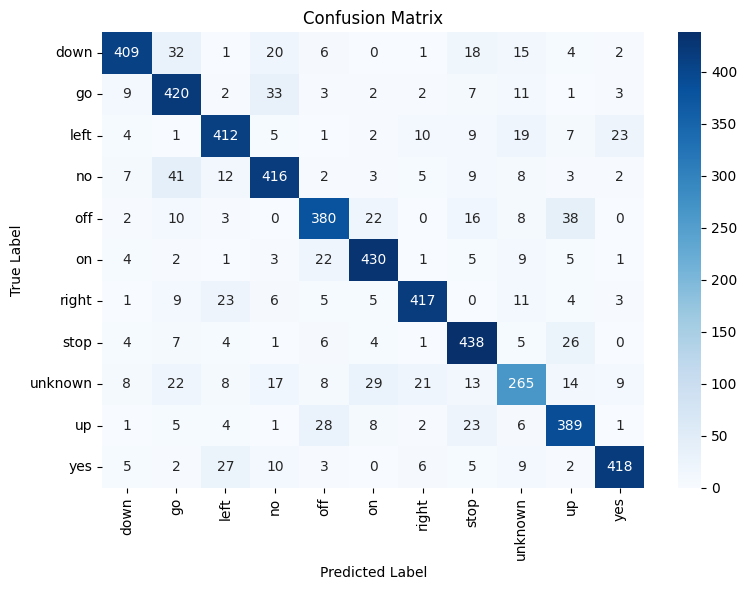

In [14]:
transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor()#,
])

train_set= ImageFolder(root='new_spectograms\\train', transform=transform)
test_set = ImageFolder(root='new_spectograms\\test', transform=transform)
val_set = ImageFolder(root='new_spectograms\\val', transform=transform)

import time
model = SimpleCNN()
initialize_weights(model)
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

 
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)   
    torch.backends.cudnn.deterministic = True   
    torch.backends.cudnn.benchmark = True

print('Dataloading...')
data_loader = DataLoader(train_set, batch_size=16, num_workers=6, generator=torch.Generator(device='cpu'),pin_memory=True, shuffle=True,persistent_workers=True, prefetch_factor=4)
data_loader_val =  DataLoader(val_set, batch_size=16, num_workers=4, generator=torch.Generator(device='cpu'), persistent_workers=True, prefetch_factor=2)

#data_loader_val = DataLoader(val_set, batch_size=16, num_workers=2,persistent_workers=True, generator=torch.Generator(device='cpu'))

# Accessing the model configuration


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

previous_time = time.time()
for epoch in range(20):  # Liczba epok
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    previous_time = time.time()
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = batch_X.to(device, non_blocking=True)   
        Y = batch_Y.to(device, non_blocking=True)   
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()     
        optimizer.step()


        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == Y).sum().item()
        total += Y.size(0)
        
        print(f"Epoch {epoch + 1}, i: {i}, Loss: {total_loss / (i+1):.4f}, Accuracy: {correct / total * 100:.2f}%, last batch accuracy: {(predicted == Y).sum().item()/Y.size(0) * 100:.2f}% Time: {time.time() - previous_time:.2f}s", end='\r')
        previous_time = time.time()

     
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")
    train_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.2f}%")

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_Y in data_loader_val:
            X = batch_X.to(device, non_blocking=True)
            Y = batch_Y.to(device, non_blocking=True)
            outputs = model(X)
            loss = criterion(outputs, Y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y).sum().item()
            total += Y.size(0)
    avg_val_loss = val_loss / len(data_loader_val)
    val_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

 model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():   
    data_loader_test = DataLoader(test_set, batch_size=16, num_workers=2, persistent_workers=True, generator=torch.Generator(device='cpu'))
    total = 0
    correct = 0
    for images, labels in data_loader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

         
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    
    precision_per_class = precision_score(all_labels, all_predictions, average=None, zero_division=0)
    recall_per_class = recall_score(all_labels, all_predictions, average=None, zero_division=0)

     classes = test_set.classes if hasattr(test_set, 'classes') else list(set(all_labels))

     df_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': precision_per_class,
        'Recall': recall_per_class
    })

    print("\nPrecision and Recall per class:")
    print(df_metrics.to_string(index=False))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [15]:
# vit

In [9]:
from torchvision.models import vit_b_16
model = vit_b_16()

In [10]:

model.heads.head = nn.Linear(model.heads.head.in_features, 11)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
initialize_weights(model)
model.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [20]:
train_set= ImageFolder(root='new_spectograms\\train', transform=transform3)
test_set = ImageFolder(root='new_spectograms\\test', transform=transform3)
val_set = ImageFolder(root='new_spectograms\\val', transform=transform3)

import time

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

 
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)   
    torch.backends.cudnn.deterministic = True   
    torch.backends.cudnn.benchmark = True

print('Dataloading...')
data_loader = DataLoader(train_set, batch_size=16, num_workers=6, generator=torch.Generator(device='cpu'),pin_memory=True, shuffle=True,persistent_workers=True, prefetch_factor=4)
data_loader_val =  DataLoader(val_set, batch_size=16, num_workers=4, generator=torch.Generator(device='cpu'), persistent_workers=True, prefetch_factor=2)

#data_loader_val = DataLoader(val_set, batch_size=16, num_workers=2,persistent_workers=True, generator=torch.Generator(device='cpu'))

# Accessing the model configuration


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

previous_time = time.time()
for epoch in range(20):  # Liczba epok
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    previous_time = time.time()
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = batch_X.to(device, non_blocking=True)   
        Y = batch_Y.to(device, non_blocking=True)   
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()     
        optimizer.step()


        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == Y).sum().item()
        total += Y.size(0)
        
        print(f"Epoch {epoch + 1}, i: {i}, Loss: {total_loss / (i+1):.4f}, Accuracy: {correct / total * 100:.2f}%, last batch accuracy: {(predicted == Y).sum().item()/Y.size(0) * 100:.2f}% Time: {time.time() - previous_time:.2f}s", end='\r')
        previous_time = time.time()

     
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")
    train_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.2f}%")

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_Y in data_loader_val:
            X = batch_X.to(device, non_blocking=True)
            Y = batch_Y.to(device, non_blocking=True)
            outputs = model(X)
            loss = criterion(outputs, Y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y).sum().item()
            total += Y.size(0)
    avg_val_loss = val_loss / len(data_loader_val)
    val_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

# 6. Ewaluacja
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():   
    data_loader_test = DataLoader(test_set, batch_size=16, num_workers=2, persistent_workers=True, generator=torch.Generator(device='cpu'))
    total = 0
    correct = 0
    for images, labels in data_loader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

         
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    
    precision_per_class = precision_score(all_labels, all_predictions, average=None, zero_division=0)
    recall_per_class = recall_score(all_labels, all_predictions, average=None, zero_division=0)

     classes = test_set.classes if hasattr(test_set, 'classes') else list(set(all_labels))

     df_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': precision_per_class,
        'Recall': recall_per_class
    })

    print("\nPrecision and Recall per class:")
    print(df_metrics.to_string(index=False))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

Dataloading...
Epoch 1, Average Loss: 1.82577, Accuracy: 38.96%, last batch accuracy: 61.54% Time: 2.06s
Epoch 1, Train Accuracy: 38.96%
Epoch 1, Validation Loss: 1.3376, Accuracy: 53.04%
Epoch 2, Average Loss: 1.17500, Accuracy: 60.69%, last batch accuracy: 100.00% Time: 1.68s
Epoch 2, Train Accuracy: 60.69%
Epoch 2, Validation Loss: 1.0867, Accuracy: 64.16%
Epoch 3, Average Loss: 1.04511, Accuracy: 64.90%, last batch accuracy: 76.92% Time: 1.66s
Epoch 3, Train Accuracy: 64.90%
Epoch 3, Validation Loss: 0.9227, Accuracy: 69.04%
Epoch 4, Average Loss: 0.96244, Accuracy: 67.42%, last batch accuracy: 69.23% Time: 1.67s
Epoch 4, Train Accuracy: 67.42%
Epoch 4, Validation Loss: 0.9480, Accuracy: 69.00%
Epoch 5, Average Loss: 0.89933, Accuracy: 69.14%, last batch accuracy: 69.23% Time: 1.69s
Epoch 5, Train Accuracy: 69.14%
Epoch 5, Validation Loss: 0.9010, Accuracy: 69.56%
Epoch 6, Average Loss: 0.84933, Accuracy: 70.47%, last batch accuracy: 69.23% Time: 1.66s
Epoch 6, Train Accuracy: 70.4

KeyboardInterrupt: 

In [21]:
train_set= ImageFolder(root='new_spectograms\\train', transform=transform3)
test_set = ImageFolder(root='new_spectograms\\test', transform=transform3)
val_set = ImageFolder(root='new_spectograms\\val', transform=transform3)

import time

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

 
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)   
    torch.backends.cudnn.deterministic = True   
    torch.backends.cudnn.benchmark = True

print('Dataloading...')
data_loader = DataLoader(train_set, batch_size=16, num_workers=6, generator=torch.Generator(device='cpu'),pin_memory=True, shuffle=True,persistent_workers=True, prefetch_factor=4)
data_loader_val =  DataLoader(val_set, batch_size=16, num_workers=4, generator=torch.Generator(device='cpu'), persistent_workers=True, prefetch_factor=2)

#data_loader_val = DataLoader(val_set, batch_size=16, num_workers=2,persistent_workers=True, generator=torch.Generator(device='cpu'))

# Accessing the model configuration


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

previous_time = time.time()
for epoch in range(10):  # Liczba epok
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    previous_time = time.time()
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = batch_X.to(device, non_blocking=True)   
        Y = batch_Y.to(device, non_blocking=True)   
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()     
        optimizer.step()


        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == Y).sum().item()
        total += Y.size(0)
        
        print(f"Epoch {epoch + 11}, i: {i}, Loss: {total_loss / (i+1):.4f}, Accuracy: {correct / total * 100:.2f}%, last batch accuracy: {(predicted == Y).sum().item()/Y.size(0) * 100:.2f}% Time: {time.time() - previous_time:.2f}s", end='\r')
        previous_time = time.time()

     
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 11}, Average Loss: {avg_loss:.4f}")
    train_accuracy = correct / total * 100
    print(f"Epoch {epoch + 11}, Train Accuracy: {train_accuracy:.2f}%")

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_Y in data_loader_val:
            X = batch_X.to(device, non_blocking=True)
            Y = batch_Y.to(device, non_blocking=True)
            outputs = model(X)
            loss = criterion(outputs, Y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y).sum().item()
            total += Y.size(0)
    avg_val_loss = val_loss / len(data_loader_val)
    val_accuracy = correct / total * 100
    print(f"Epoch {epoch + 11}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

# 6. Ewaluacja
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():   
    data_loader_test = DataLoader(test_set, batch_size=16, num_workers=2, persistent_workers=True, generator=torch.Generator(device='cpu'))
    total = 0
    correct = 0
    for images, labels in data_loader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

         
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    
    precision_per_class = precision_score(all_labels, all_predictions, average=None, zero_division=0)
    recall_per_class = recall_score(all_labels, all_predictions, average=None, zero_division=0)

     classes = test_set.classes if hasattr(test_set, 'classes') else list(set(all_labels))

     df_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': precision_per_class,
        'Recall': recall_per_class
    })

    print("\nPrecision and Recall per class:")
    print(df_metrics.to_string(index=False))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

Dataloading...
Epoch 11, Average Loss: 0.66944, Accuracy: 77.10%, last batch accuracy: 92.31% Time: 2.40ss
Epoch 11, Train Accuracy: 77.10%
Epoch 11, Validation Loss: 0.7830, Accuracy: 73.18%


KeyboardInterrupt: 

In [22]:
torch.save({
    'epoch': 12,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_loss,
}, "checkpoint.pth")


In [23]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict()
}, "small_checkpoint.pth")


In [6]:
from torchvision.models import vit_b_16
model = vit_b_16()
model.heads.head = nn.Linear(model.heads.head.in_features, 11)


In [9]:
checkpoint = torch.load("small_checkpoint.pth", map_location='cpu')  

model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']


C:\Users\danci\AppData\Local\Temp\ipykernel_11144\1813652508.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("small_checkpoint.pth", map_location

Dataloading...
Epoch 12, Average Loss: 0.63222, Accuracy: 78.19%, last batch accuracy: 76.92% Time: 2.02ss
Epoch 12, Train Accuracy: 78.19%
Epoch 12, Validation Loss: 0.8200, Accuracy: 73.41%
Epoch 13, Average Loss: 0.59633, Accuracy: 79.14%, last batch accuracy: 92.31% Time: 1.02ss
Epoch 13, Train Accuracy: 79.14%
Epoch 13, Validation Loss: 0.8374, Accuracy: 71.62%
Epoch 14, Average Loss: 0.58688, Accuracy: 79.51%, last batch accuracy: 84.62% Time: 1.02ss
Epoch 14, Train Accuracy: 79.51%
Epoch 14, Validation Loss: 0.8009, Accuracy: 73.29%
Epoch 15, Average Loss: 0.54944, Accuracy: 80.77%, last batch accuracy: 76.92% Time: 0.98sss
Epoch 15, Train Accuracy: 80.77%
Epoch 15, Validation Loss: 0.8502, Accuracy: 73.18%
Epoch 16, Average Loss: 0.50522, Accuracy: 82.29%, last batch accuracy: 76.92% Time: 1.01ss
Epoch 16, Train Accuracy: 82.29%
Epoch 16, Validation Loss: 0.8164, Accuracy: 73.70%
Epoch 17, Average Loss: 0.49744, Accuracy: 82.57%, last batch accuracy: 61.54% Time: 1.00sss
Epoch 

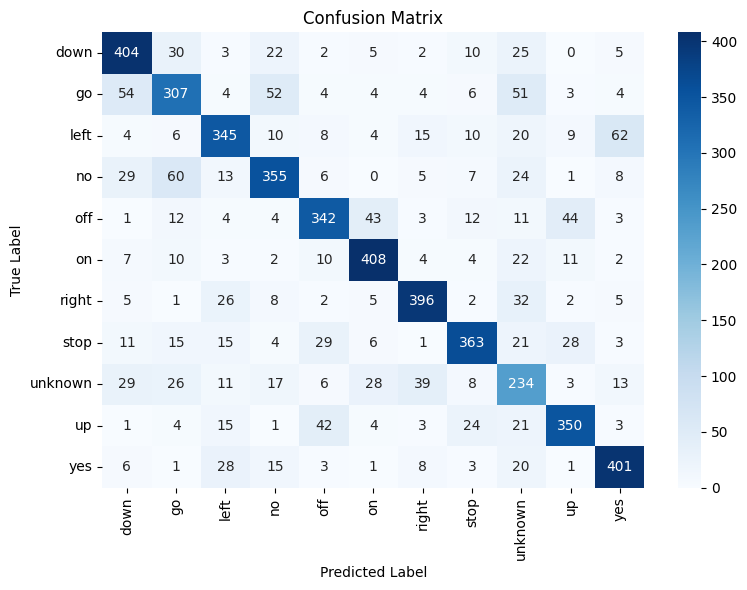

In [10]:
train_set= ImageFolder(root='new_spectograms\\train', transform=transform3)
test_set = ImageFolder(root='new_spectograms\\test', transform=transform3)
val_set = ImageFolder(root='new_spectograms\\val', transform=transform3)

import time

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

 
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)   
    torch.backends.cudnn.deterministic = True   
    torch.backends.cudnn.benchmark = True

print('Dataloading...')
data_loader = DataLoader(train_set, batch_size=16, num_workers=6, generator=torch.Generator(device='cpu'),pin_memory=True, shuffle=True,persistent_workers=True, prefetch_factor=4)
data_loader_val =  DataLoader(val_set, batch_size=16, num_workers=4, generator=torch.Generator(device='cpu'), persistent_workers=True, prefetch_factor=2)

#data_loader_val = DataLoader(val_set, batch_size=16, num_workers=2,persistent_workers=True, generator=torch.Generator(device='cpu'))

# Accessing the model configuration


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

previous_time = time.time()
for epoch in range(10):  # Liczba epok
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    previous_time = time.time()
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = batch_X.to(device, non_blocking=True)   
        Y = batch_Y.to(device, non_blocking=True)   
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()     
        optimizer.step()


        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == Y).sum().item()
        total += Y.size(0)
        
        print(f"Epoch {epoch + 12}, i: {i}, Loss: {total_loss / (i+1):.4f}, Accuracy: {correct / total * 100:.2f}%, last batch accuracy: {(predicted == Y).sum().item()/Y.size(0) * 100:.2f}% Time: {time.time() - previous_time:.2f}s", end='\r')
        previous_time = time.time()

     
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 12}, Average Loss: {avg_loss:.4f}")
    train_accuracy = correct / total * 100
    print(f"Epoch {epoch + 12}, Train Accuracy: {train_accuracy:.2f}%")

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_Y in data_loader_val:
            X = batch_X.to(device, non_blocking=True)
            Y = batch_Y.to(device, non_blocking=True)
            outputs = model(X)
            loss = criterion(outputs, Y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y).sum().item()
            total += Y.size(0)
    avg_val_loss = val_loss / len(data_loader_val)
    val_accuracy = correct / total * 100
    print(f"Epoch {epoch + 12}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

# 6. Ewaluacja
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():   
    data_loader_test = DataLoader(test_set, batch_size=16, num_workers=2, persistent_workers=True, generator=torch.Generator(device='cpu'))
    total = 0
    correct = 0
    for images, labels in data_loader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

         
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    
    precision_per_class = precision_score(all_labels, all_predictions, average=None, zero_division=0)
    recall_per_class = recall_score(all_labels, all_predictions, average=None, zero_division=0)

     classes = test_set.classes if hasattr(test_set, 'classes') else list(set(all_labels))

     df_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': precision_per_class,
        'Recall': recall_per_class
    })

    print("\nPrecision and Recall per class:")
    print(df_metrics.to_string(index=False))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

Dataloading...
Epoch 1, Average Loss: 1.41100, Accuracy: 51.79%, last batch accuracy: 76.92% Time: 2.11s
Epoch 1, Train Accuracy: 51.79%
Epoch 1, Validation Loss: 1.0512, Accuracy: 63.74%
Epoch 2, Average Loss: 0.95499, Accuracy: 67.84%, last batch accuracy: 84.62% Time: 11.09s
Epoch 2, Train Accuracy: 67.84%
Epoch 2, Validation Loss: 0.8802, Accuracy: 71.09%
Epoch 3, Average Loss: 0.81100, Accuracy: 72.30%, last batch accuracy: 76.92% Time: 0.97ss
Epoch 3, Train Accuracy: 72.30%
Epoch 3, Validation Loss: 0.8421, Accuracy: 71.80%
Epoch 4, Average Loss: 0.69733, Accuracy: 76.35%, last batch accuracy: 76.92% Time: 1.00ss
Epoch 4, Train Accuracy: 76.35%
Epoch 4, Validation Loss: 0.9005, Accuracy: 70.61%
Epoch 5, Average Loss: 0.60566, Accuracy: 79.04%, last batch accuracy: 84.62% Time: 1.02ss
Epoch 5, Train Accuracy: 79.04%
Epoch 5, Validation Loss: 0.7829, Accuracy: 74.90%
Epoch 6, Average Loss: 0.51755, Accuracy: 82.29%, last batch accuracy: 84.62% Time: 11.10s
Epoch 6, Train Accuracy: 

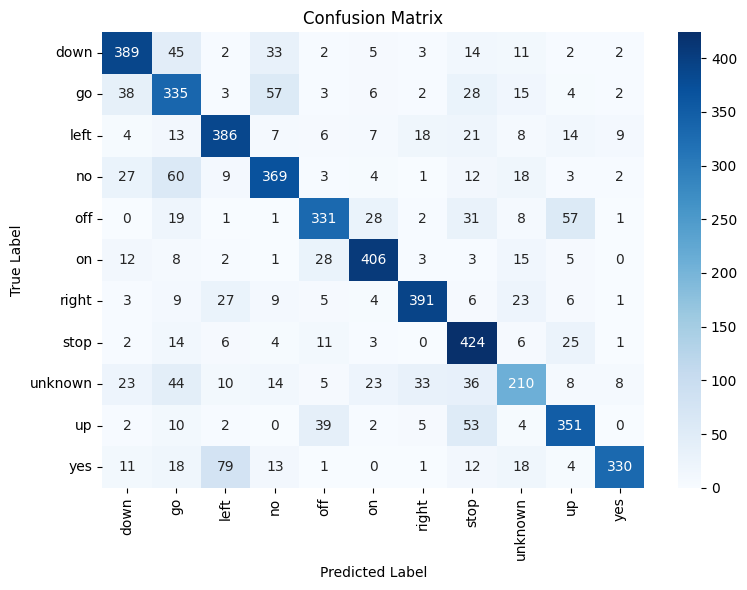

In [11]:
from torchvision.models import vit_b_16
model = vit_b_16()
model.heads.head = nn.Linear(model.heads.head.in_features, 11)

train_set= ImageFolder(root='new_spectograms\\train', transform=transform3)
test_set = ImageFolder(root='new_spectograms\\test', transform=transform3)
val_set = ImageFolder(root='new_spectograms\\val', transform=transform3)

import time

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

 
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)   
    torch.backends.cudnn.deterministic = True   
    torch.backends.cudnn.benchmark = True

print('Dataloading...')
data_loader = DataLoader(train_set, batch_size=16, num_workers=6, generator=torch.Generator(device='cpu'),pin_memory=True, shuffle=True,persistent_workers=True, prefetch_factor=4)
data_loader_val =  DataLoader(val_set, batch_size=16, num_workers=4, generator=torch.Generator(device='cpu'), persistent_workers=True, prefetch_factor=2)

#data_loader_val = DataLoader(val_set, batch_size=16, num_workers=2,persistent_workers=True, generator=torch.Generator(device='cpu'))

# Accessing the model configuration


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00003)
criterion = torch.nn.CrossEntropyLoss()

previous_time = time.time()
for epoch in range(20):  # Liczba epok
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    previous_time = time.time()
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = batch_X.to(device, non_blocking=True)   
        Y = batch_Y.to(device, non_blocking=True)   
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()     
        optimizer.step()


        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == Y).sum().item()
        total += Y.size(0)
        
        print(f"Epoch {epoch + 1}, i: {i}, Loss: {total_loss / (i+1):.4f}, Accuracy: {correct / total * 100:.2f}%, last batch accuracy: {(predicted == Y).sum().item()/Y.size(0) * 100:.2f}% Time: {time.time() - previous_time:.2f}s", end='\r')
        previous_time = time.time()

     
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")
    train_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.2f}%")

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_Y in data_loader_val:
            X = batch_X.to(device, non_blocking=True)
            Y = batch_Y.to(device, non_blocking=True)
            outputs = model(X)
            loss = criterion(outputs, Y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y).sum().item()
            total += Y.size(0)
    avg_val_loss = val_loss / len(data_loader_val)
    val_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

# 6. Ewaluacja
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():   
    data_loader_test = DataLoader(test_set, batch_size=16, num_workers=2, persistent_workers=True, generator=torch.Generator(device='cpu'))
    total = 0
    correct = 0
    for images, labels in data_loader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

         
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    
    precision_per_class = precision_score(all_labels, all_predictions, average=None, zero_division=0)
    recall_per_class = recall_score(all_labels, all_predictions, average=None, zero_division=0)

     classes = test_set.classes if hasattr(test_set, 'classes') else list(set(all_labels))

     df_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': precision_per_class,
        'Recall': recall_per_class
    })

    print("\nPrecision and Recall per class:")
    print(df_metrics.to_string(index=False))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

Dataloading...
Epoch 1, Average Loss: 1.36944, Accuracy: 52.85%, last batch accuracy: 76.92% Time: 1.38s
Epoch 1, Train Accuracy: 52.85%
Epoch 1, Validation Loss: 0.9778, Accuracy: 65.27%
Epoch 2, Average Loss: 0.85088, Accuracy: 70.60%, last batch accuracy: 84.62% Time: 1.31ss
Epoch 2, Train Accuracy: 70.60%
Epoch 2, Validation Loss: 0.8270, Accuracy: 71.62%
Epoch 3, Average Loss: 0.70755, Accuracy: 75.24%, last batch accuracy: 92.31% Time: 1.38s
Epoch 3, Train Accuracy: 75.24%
Epoch 3, Validation Loss: 0.7451, Accuracy: 74.60%
Epoch 4, Average Loss: 0.58166, Accuracy: 79.86%, last batch accuracy: 76.92% Time: 1.36ss
Epoch 4, Train Accuracy: 79.86%
Epoch 4, Validation Loss: 0.7713, Accuracy: 74.19%
Epoch 5, Average Loss: 0.47455, Accuracy: 83.41%, last batch accuracy: 92.31% Time: 11.66s
Epoch 5, Train Accuracy: 83.41%
Epoch 5, Validation Loss: 0.7355, Accuracy: 76.20%
Epoch 6, Average Loss: 0.37066, Accuracy: 87.10%, last batch accuracy: 76.92% Time: 1.38ss
Epoch 6, Train Accuracy: 8

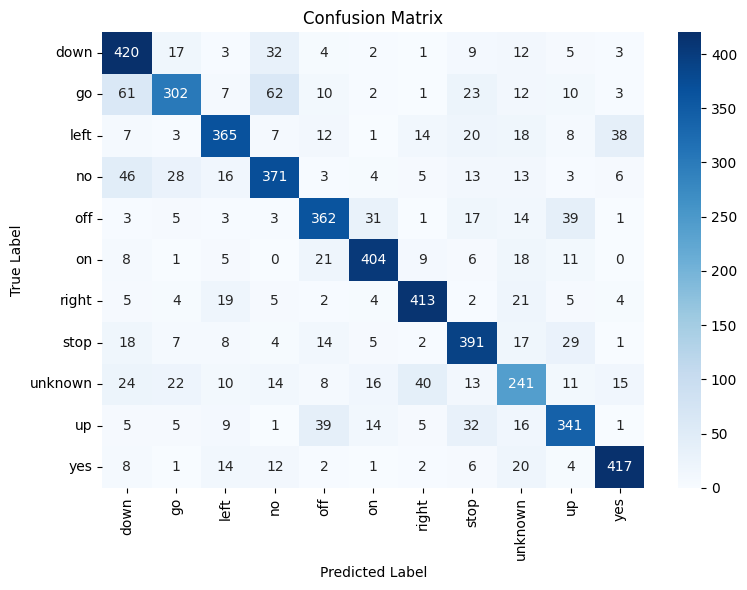

In [12]:
from torchvision.models import vit_b_16
model = vit_b_16()
model.heads.head = nn.Linear(model.heads.head.in_features, 11)

train_set= ImageFolder(root='new_spectograms\\train', transform=transform3)
test_set = ImageFolder(root='new_spectograms\\test', transform=transform3)
val_set = ImageFolder(root='new_spectograms\\val', transform=transform3)

import time

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

 
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)   
    torch.backends.cudnn.deterministic = True   
    torch.backends.cudnn.benchmark = True

print('Dataloading...')
data_loader = DataLoader(train_set, batch_size=16, num_workers=6, generator=torch.Generator(device='cpu'),pin_memory=True, shuffle=True,persistent_workers=True, prefetch_factor=4)
data_loader_val =  DataLoader(val_set, batch_size=16, num_workers=4, generator=torch.Generator(device='cpu'), persistent_workers=True, prefetch_factor=2)

#data_loader_val = DataLoader(val_set, batch_size=16, num_workers=2,persistent_workers=True, generator=torch.Generator(device='cpu'))

# Accessing the model configuration


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)
criterion = torch.nn.CrossEntropyLoss()

previous_time = time.time()
for epoch in range(20):  # Liczba epok
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    previous_time = time.time()
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = batch_X.to(device, non_blocking=True)   
        Y = batch_Y.to(device, non_blocking=True)   
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()     
        optimizer.step()


        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == Y).sum().item()
        total += Y.size(0)
        
        print(f"Epoch {epoch + 1}, i: {i}, Loss: {total_loss / (i+1):.4f}, Accuracy: {correct / total * 100:.2f}%, last batch accuracy: {(predicted == Y).sum().item()/Y.size(0) * 100:.2f}% Time: {time.time() - previous_time:.2f}s", end='\r')
        previous_time = time.time()

     
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")
    train_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.2f}%")

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_Y in data_loader_val:
            X = batch_X.to(device, non_blocking=True)
            Y = batch_Y.to(device, non_blocking=True)
            outputs = model(X)
            loss = criterion(outputs, Y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y).sum().item()
            total += Y.size(0)
    avg_val_loss = val_loss / len(data_loader_val)
    val_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

# 6. Ewaluacja
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():   
    data_loader_test = DataLoader(test_set, batch_size=16, num_workers=2, persistent_workers=True, generator=torch.Generator(device='cpu'))
    total = 0
    correct = 0
    for images, labels in data_loader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

         
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    
    precision_per_class = precision_score(all_labels, all_predictions, average=None, zero_division=0)
    recall_per_class = recall_score(all_labels, all_predictions, average=None, zero_division=0)

     classes = test_set.classes if hasattr(test_set, 'classes') else list(set(all_labels))

     df_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': precision_per_class,
        'Recall': recall_per_class
    })

    print("\nPrecision and Recall per class:")
    print(df_metrics.to_string(index=False))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [8]:
# timm

In [13]:

import timm
import torch.nn as nn
model3 = timm.create_model("deit_tiny_patch16_224")

model3.head = nn.Linear(model3.head.in_features, 11)   

initialize_weights(model3)   

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model1.to(device)

D:\anaconda\envs\torch_envi\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataloading...
Epoch 1, Average Loss: 1.81899, Accuracy: 35.51%, last batch accuracy: 61.54% Time: 0.36s
Epoch 1, Train Accuracy: 35.51%
Epoch 1, Validation Loss: 1.1895, Accuracy: 59.01%
Epoch 2, Average Loss: 1.05677, Accuracy: 64.41%, last batch accuracy: 76.92% Time: 0.10s
Epoch 2, Train Accuracy: 64.41%
Epoch 2, Validation Loss: 1.0174, Accuracy: 66.09%
Epoch 3, Average Loss: 0.90033, Accuracy: 69.39%, last batch accuracy: 84.62% Time: 0.11s
Epoch 3, Train Accuracy: 69.39%
Epoch 3, Validation Loss: 0.8658, Accuracy: 71.32%
Epoch 4, Average Loss: 0.80266, Accuracy: 72.60%, last batch accuracy: 61.54% Time: 0.10s
Epoch 4, Train Accuracy: 72.60%
Epoch 4, Validation Loss: 0.8395, Accuracy: 71.47%
Epoch 5, Average Loss: 0.73233, Accuracy: 75.04%, last batch accuracy: 76.92% Time: 0.11ss
Epoch 5, Train Accuracy: 75.04%
Epoch 5, Validation Loss: 0.7859, Accuracy: 74.15%
Epoch 6, Average Loss: 0.67800, Accuracy: 76.65%, last batch accuracy: 84.62% Time: 0.10ss
Epoch 6, Train Accuracy: 76.

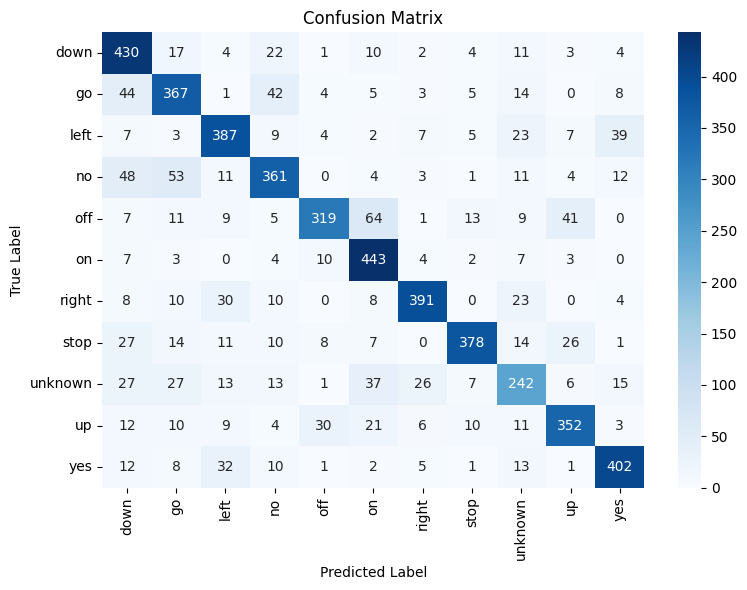

In [14]:

import time
model3 = timm.create_model("deit_tiny_patch16_224")
model3.head = nn.Linear(model3.head.in_features, 11)   
initialize_weights(model3)   
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3.to(device)

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

 
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)   
    torch.backends.cudnn.deterministic = True   
    torch.backends.cudnn.benchmark = True

print('Dataloading...')
data_loader = DataLoader(train_set, batch_size=16, num_workers=6, generator=torch.Generator(device='cpu'),pin_memory=True, shuffle=True,persistent_workers=True, prefetch_factor=4)
data_loader_val =  DataLoader(val_set, batch_size=16, num_workers=4, generator=torch.Generator(device='cpu'), persistent_workers=True, prefetch_factor=2)

#data_loader_val = DataLoader(val_set, batch_size=16, num_workers=2,persistent_workers=True, generator=torch.Generator(device='cpu'))

# Accessing the model configuration


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3.to(device)
optimizer = torch.optim.AdamW(model3.parameters(), lr=0.00001)
criterion = torch.nn.CrossEntropyLoss()

previous_time = time.time()
for epoch in range(20):  # Liczba epok
    model3.train()
    total_loss = 0
    correct = 0
    total = 0
    previous_time = time.time()
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = batch_X.to(device, non_blocking=True)   
        Y = batch_Y.to(device, non_blocking=True)   
        optimizer.zero_grad()
        outputs = model3(X)
        loss = criterion(outputs, Y)
        loss.backward()     
        optimizer.step()


        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == Y).sum().item()
        total += Y.size(0)
        
        print(f"Epoch {epoch + 1}, i: {i}, Loss: {total_loss / (i+1):.4f}, Accuracy: {correct / total * 100:.2f}%, last batch accuracy: {(predicted == Y).sum().item()/Y.size(0) * 100:.2f}% Time: {time.time() - previous_time:.2f}s", end='\r')
        previous_time = time.time()

     
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")
    train_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.2f}%")

    model3.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_Y in data_loader_val:
            X = batch_X.to(device, non_blocking=True)
            Y = batch_Y.to(device, non_blocking=True)
            outputs = model3(X)
            loss = criterion(outputs, Y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y).sum().item()
            total += Y.size(0)
    avg_val_loss = val_loss / len(data_loader_val)
    val_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

 model3.eval()
all_predictions = []
all_labels = []

with torch.no_grad():   
    data_loader_test = DataLoader(test_set, batch_size=16, num_workers=2, persistent_workers=True, generator=torch.Generator(device='cpu'))
    total = 0
    correct = 0
    for images, labels in data_loader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = model3(images)
        _, predicted = torch.max(outputs, 1)

         
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    
    precision_per_class = precision_score(all_labels, all_predictions, average=None, zero_division=0)
    recall_per_class = recall_score(all_labels, all_predictions, average=None, zero_division=0)

     classes = test_set.classes if hasattr(test_set, 'classes') else list(set(all_labels))

     df_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': precision_per_class,
        'Recall': recall_per_class
    })

    print("\nPrecision and Recall per class:")
    print(df_metrics.to_string(index=False))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [15]:
import timm
import torch.nn as nn
model3 = timm.create_model("deit_tiny_patch16_224")

model3.head = nn.Linear(model3.head.in_features, 11)   

initialize_weights(model3)   

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model1.to(device)

Dataloading...
Epoch 1, Average Loss: 1.61311, Accuracy: 43.27%, last batch accuracy: 84.62% Time: 0.10s
Epoch 1, Train Accuracy: 43.27%
Epoch 1, Validation Loss: 1.0461, Accuracy: 63.26%
Epoch 2, Average Loss: 0.96200, Accuracy: 67.28%, last batch accuracy: 92.31% Time: 0.11s
Epoch 2, Train Accuracy: 67.28%
Epoch 2, Validation Loss: 0.9032, Accuracy: 69.79%
Epoch 3, Average Loss: 0.83488, Accuracy: 71.12%, last batch accuracy: 92.31% Time: 0.10s
Epoch 3, Train Accuracy: 71.12%
Epoch 3, Validation Loss: 0.8120, Accuracy: 72.85%
Epoch 4, Average Loss: 0.75355, Accuracy: 73.93%, last batch accuracy: 69.23% Time: 0.11ss
Epoch 4, Train Accuracy: 73.93%
Epoch 4, Validation Loss: 0.8170, Accuracy: 72.51%
Epoch 5, Average Loss: 0.69155, Accuracy: 75.79%, last batch accuracy: 84.62% Time: 0.10ss
Epoch 5, Train Accuracy: 75.79%
Epoch 5, Validation Loss: 0.7839, Accuracy: 73.63%
Epoch 6, Average Loss: 0.63844, Accuracy: 77.41%, last batch accuracy: 76.92% Time: 0.11ss
Epoch 6, Train Accuracy: 77

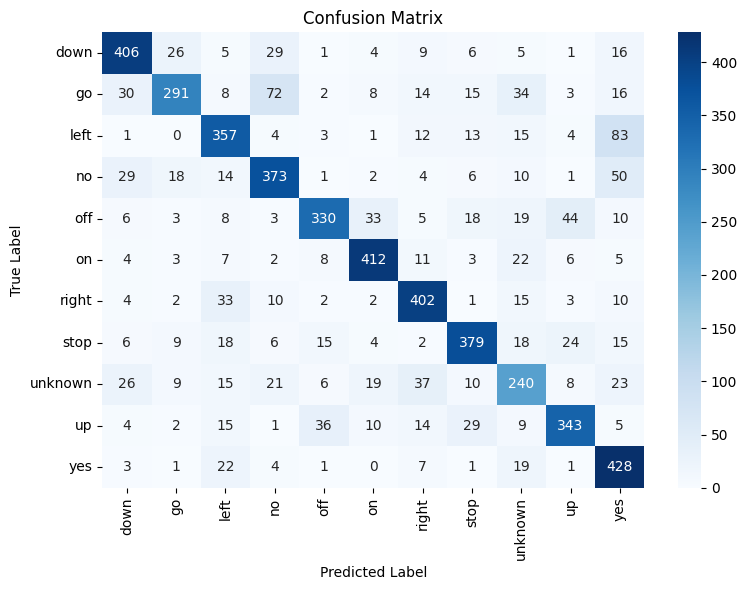

In [16]:

import time
model3 = timm.create_model("deit_tiny_patch16_224")
model3.head = nn.Linear(model3.head.in_features, 11)   
initialize_weights(model3)   
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3.to(device)

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

 
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)   
    torch.backends.cudnn.deterministic = True   
    torch.backends.cudnn.benchmark = True

print('Dataloading...')
data_loader = DataLoader(train_set, batch_size=16, num_workers=6, generator=torch.Generator(device='cpu'),pin_memory=True, shuffle=True,persistent_workers=True, prefetch_factor=4)
data_loader_val =  DataLoader(val_set, batch_size=16, num_workers=4, generator=torch.Generator(device='cpu'), persistent_workers=True, prefetch_factor=2)

#data_loader_val = DataLoader(val_set, batch_size=16, num_workers=2,persistent_workers=True, generator=torch.Generator(device='cpu'))

# Accessing the model configuration


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3.to(device)
optimizer = torch.optim.AdamW(model3.parameters(), lr=0.00003)
criterion = torch.nn.CrossEntropyLoss()

previous_time = time.time()
for epoch in range(20):  # Liczba epok
    model3.train()
    total_loss = 0
    correct = 0
    total = 0
    previous_time = time.time()
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = batch_X.to(device, non_blocking=True)   
        Y = batch_Y.to(device, non_blocking=True)   
        optimizer.zero_grad()
        outputs = model3(X)
        loss = criterion(outputs, Y)
        loss.backward()     
        optimizer.step()


        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == Y).sum().item()
        total += Y.size(0)
        
        print(f"Epoch {epoch + 1}, i: {i}, Loss: {total_loss / (i+1):.4f}, Accuracy: {correct / total * 100:.2f}%, last batch accuracy: {(predicted == Y).sum().item()/Y.size(0) * 100:.2f}% Time: {time.time() - previous_time:.2f}s", end='\r')
        previous_time = time.time()

     
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")
    train_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.2f}%")

    model3.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_Y in data_loader_val:
            X = batch_X.to(device, non_blocking=True)
            Y = batch_Y.to(device, non_blocking=True)
            outputs = model3(X)
            loss = criterion(outputs, Y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y).sum().item()
            total += Y.size(0)
    avg_val_loss = val_loss / len(data_loader_val)
    val_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

 model3.eval()
all_predictions = []
all_labels = []

with torch.no_grad():   
    data_loader_test = DataLoader(test_set, batch_size=16, num_workers=2, persistent_workers=True, generator=torch.Generator(device='cpu'))
    total = 0
    correct = 0
    for images, labels in data_loader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = model3(images)
        _, predicted = torch.max(outputs, 1)

         
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    
    precision_per_class = precision_score(all_labels, all_predictions, average=None, zero_division=0)
    recall_per_class = recall_score(all_labels, all_predictions, average=None, zero_division=0)

     classes = test_set.classes if hasattr(test_set, 'classes') else list(set(all_labels))

     df_metrics = pd.DataFrame({
        'Class': classes,
        'Precision': precision_per_class,
        'Recall': recall_per_class
    })

    print("\nPrecision and Recall per class:")
    print(df_metrics.to_string(index=False))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()